In [69]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../scripts')))
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.express as px

In [107]:
import warnings
warnings.filterwarnings('ignore')
import dvc.api


In [71]:
import numpy as np
import pandas as pd
import plots
import scipy.stats as scs
import random
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
from sklearn import tree
import scipy.stats as stat
from helper import Helper
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score




In [72]:
CSV_PATH = "../Data/data.csv"

In [73]:
helper = Helper()

In [74]:
df = helper.read_csv(CSV_PATH)
df.head()

file read as csv


,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [75]:

def drop_no_responds(df):
    cleaned_df = df.query("not (yes == 0 & no == 0)")
    return cleaned_df




### Data Transformation

In [76]:
cleaned_df = drop_no_responds(df)
cleaned_df['aware'] = cleaned_df['yes'].map(lambda x: x==1)
cleaned_df = cleaned_df.drop(columns = ['yes', 'no', 'auction_id'], axis=1)

In [77]:

CLEANED_CSV_PATH = "../Data/clean_data.csv"
helper.save_csv(cleaned_df, CLEANED_CSV_PATH)

File Successfully Saved.!!!


,experiment,date,hour,device_make,platform_os,browser,aware
2,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,False
16,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,True
20,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,False
23,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,True
27,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,False
...,...,...,...,...,...,...,...
8059,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,True
8063,exposed,2020-07-04,1,Generic Smartphone,6,Chrome Mobile,True
8064,control,2020-07-09,7,Generic Smartphone,6,Chrome Mobile,False
8069,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,False


### Data preparation

##### Label Encoding

In [28]:
def encode_labels(df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    aware_encoder = preprocessing.LabelEncoder()
    
    df['date'] = date_encoder.fit_transform(df['date'])
    df['device_make'] = device_encoder.fit_transform(df['device_make'])
    df['browser'] = browser_encoder.fit_transform(df['browser'])
    df['experiment'] = experiment_encoder.fit_transform(cleaned_df['experiment'])
    df['browser'] = aware_encoder.fit_transform(df['browser'])
    df['aware'] = aware_encoder.fit_transform(df['aware'])


    
    return df
    
    

#### Spliting the data based on browser and platform_os

In [85]:

def feature_data(cleaned_df):
    
    broweser_df = cleaned_df[["experiment", "hour", "date", 'device_make', 'browser', 'aware']]
    platfrom_df = cleaned_df[["experiment", "hour", "date", 'device_make', 'platform_os', 'aware']]

    

    return broweser_df, platfrom_df


In [29]:

encoded_df = encode_labels(cleaned_df)


In [ ]:
broweser_df, platfrom_df = feature_data(encoded_df)

### Model Building

#### Loss function

In [31]:
def loss_function(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    return rmse


#### Decision Tree Model

In [102]:
class DecisionTreesModel:
    
    def __init__(self, X_train, X_test, y_train, y_test, max_depth=5):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.clf = DecisionTreeClassifier(max_depth=4)
        
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        for i in range(folds):
            train_index, valid_index = next(iterator)
            
            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]
                        
            self.clf = self.clf.fit(X_train, y_train)
            
            vali_pred = self.clf.predict(X_valid)
            
            accuracy = self.calculate_score(y_valid
                                              , vali_pred)
            
            loss = loss_function(y_valid, vali_pred)
            
            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()
            
            acc_arr.append(accuracy)
            loss_arr.append(loss)

            
        return self.clf, acc_arr, loss_arr
    
    def test(self):
        
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(y_pred, self.y_test)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        
        loss = loss_function(self.y_test, y_pred)
        
        return accuracy, loss,  report, matrix
    
    def get_feature_importance(self):
        importance = self.clf.feature_importances_
        fi_df = pd.DataFrame()
        
        fi_df['feature'] = self.X_train.columns.to_list()
        fi_df['feature_importances'] = importance
        
        return fi_df
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of DecisionTreesModel is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of DecisionTreesModel is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)


        
    
    
    


#### Train Test Split

In [103]:
# feature_cols = ["experiment", "hour", "date", 'device_make', "platform_os",  "browser"]
feature_cols = ["experiment", "hour", "date", 'device_make']

X = encoded_df[feature_cols]
y = encoded_df[['aware']]

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

#### Model Training Using DecisionTreesModel

In [104]:

decisionTreesModel = DecisionTreesModel(X_train, X_test,  y_train, y_test)

clf, acc_arr, loss_arr = decisionTreesModel.train(5)


step 0: Validation Accuracy of DecisionTreesModel is: 0.554
step 0: Validation Loss of DecisionTreesModel is: 0.668

step 1: Validation Accuracy of DecisionTreesModel is: 0.527
step 1: Validation Loss of DecisionTreesModel is: 0.688

step 2: Validation Accuracy of DecisionTreesModel is: 0.554
step 2: Validation Loss of DecisionTreesModel is: 0.668

step 3: Validation Accuracy of DecisionTreesModel is: 0.502
step 3: Validation Loss of DecisionTreesModel is: 0.706

step 4: Validation Accuracy of DecisionTreesModel is: 0.543
step 4: Validation Loss of DecisionTreesModel is: 0.676



#### Evaluating our model

step 1: Test Accuracy of DecisionTreesModel is: 0.568
Test Metrics
              precision    recall  f1-score   support

           0       0.95      0.55      0.70       113
           1       0.15      0.75      0.25        12

    accuracy                           0.57       125
   macro avg       0.55      0.65      0.47       125
weighted avg       0.88      0.57      0.65       125

Loss on test data is: 0.657



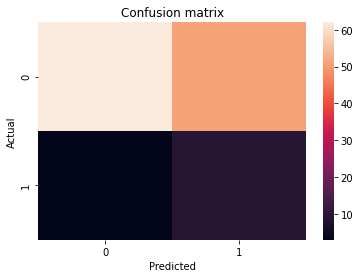

In [105]:

test_acc, loss, report, confusion_matrix = decisionTreesModel.test()
print(f"Loss on test data is: {loss:.3f}")
print()


### Calculating feature importance

In [106]:
decisionTreesModel.get_feature_importance()

,feature,feature_importances
0,experiment,0.000000
1,hour,0.453469
2,date,0.176664
3,device_make,0.369866


Our experiment feature has feature importances of 0. This infers that 'experiment' feature is not the main driving feature of the Decision Tree Model. It is not contributing much for awareness. The most predictor for the Decision Tree Model is hour which with feature importance of 0.45 followed by device_make. But this is a result of a decision tree model with max-depth of 4. if we increase the max-depth, we might observe a differnt result in feature importance.

### Visualzing feature importance

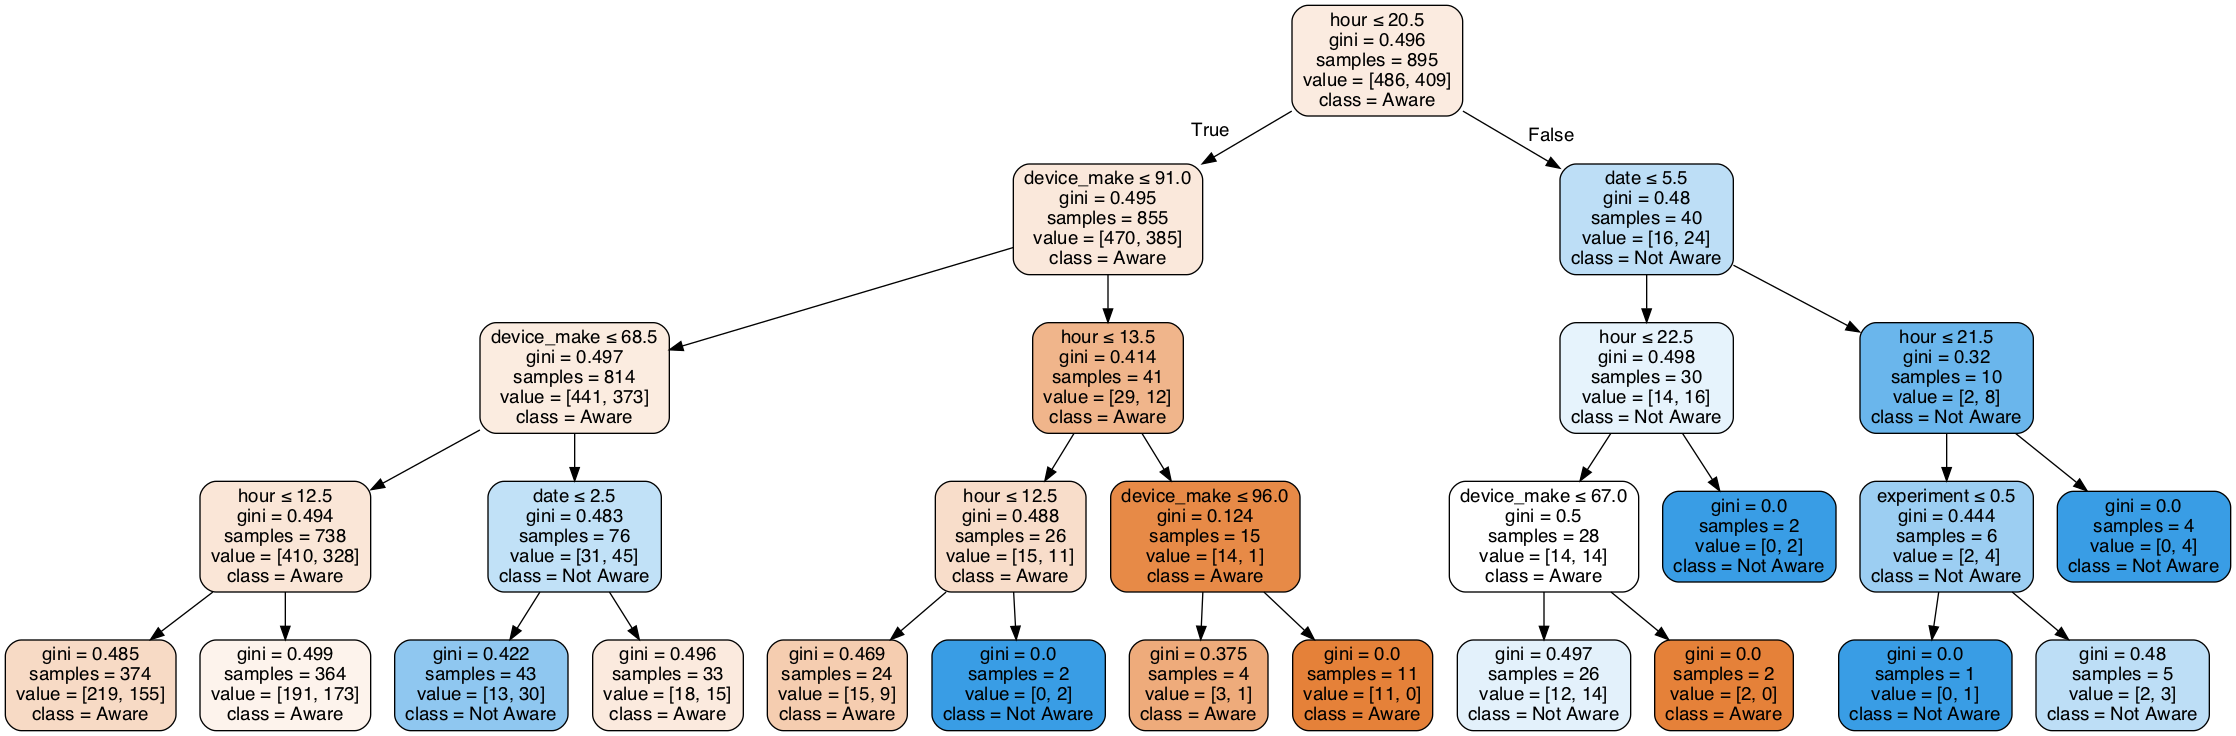

In [93]:
dot_data = StringIO()

leaves_parallel=False
feature_cols = ["experiment", "hour", "date", 'device_make']
out_put_file = "AbTestDecisionTree.dot"

dot_data = export_graphviz(clf, out_file=out_put_file,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['Aware','Not Aware'])

graph = pydotplus.graphviz.graph_from_dot_file(out_put_file)
graph.write_png('AbTestDecisionTree.png')

Image(graph.create_png())


Our experiment feature is found on the 4th level depth of the Decision Tree. And it only divided leaves with '0' (Not Aware) out come. This infers that 'experiment' feature is not the main driving feature of the Decision Tree Model. It is not contributing much for awareness. The most predictor for the Decision Tree Model is hour which is the root node

In [94]:
class LogesticRegressionModel:
    
    def __init__(self, X_train, X_test, y_train, y_test):
        
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.clf = LogisticRegression()
        
    def train(self, folds=1):
        
        kf = KFold(n_splits = folds)
        
        iterator = kf.split(self.X_train)
        
        loss_arr = []
        acc_arr = []
        for i in range(folds):
            train_index, valid_index = next(iterator)
            
            X_train, y_train = self.X_train.iloc[train_index], self.y_train.iloc[train_index]
            X_valid, y_valid = self.X_train.iloc[valid_index], self.y_train.iloc[valid_index]
                        
            self.clf = self.clf.fit(X_train, y_train)
            
            vali_pred = self.clf.predict(X_valid)
            
            accuracy = self.calculate_score(y_valid, vali_pred)
            loss = loss_function(y_valid, vali_pred)
            
            self.__printAccuracy(accuracy, i, label="Validation")
            self.__printLoss(loss, i, label="Validation")
            print()
            
            acc_arr.append(accuracy)
            loss_arr.append(loss)

            
        return self.clf, acc_arr, loss_arr
    
    def test(self):
        y_pred = self.clf.predict(self.X_test)
        
        accuracy = self.calculate_score(self.y_test, y_pred)
        self.__printAccuracy(accuracy, label="Test")
        
        report = self.report(y_pred, self.y_test)
        matrix = self.confusion_matrix(y_pred, self.y_test)
        loss = loss_function(self.y_test, y_pred)

        
        return accuracy, loss, report, matrix 
    
    def __printAccuracy(self, acc, step=1, label=""):
        print(f"step {step}: {label} Accuracy of LogesticRegression is: {acc:.3f}")
    
    def __printLoss(self, loss, step=1, label=""):
        print(f"step {step}: {label} Loss of LogesticRegression is: {loss:.3f}")
    
    def calculate_score(self, pred, actual):
        return metrics.accuracy_score(actual, pred)
    
    def report(self, pred, actual):
        print("Test Metrics")
        print("================")
        print(metrics.classification_report(pred, actual))
        return metrics.classification_report(pred, actual)
    
    def confusion_matrix(self, pred, actual):
        ax=sns.heatmap(pd.DataFrame(metrics.confusion_matrix(pred, actual)))
        plt.title('Confusion matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        return metrics.confusion_matrix(pred, actual)
    
    def get_p_values(self):
        """ 
        Calcualting p_values for logestic regression.
        code refered from the following link
        https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
        
        """
        denom = (2.0*(1.0+np.cosh(self.clf.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.sqrt(np.diagonal(Cramer_Rao))
        z_scores = self.clf.coef_[0]/sigma_estimates # z-score 
        p_values = [stat.norm.sf(abs(x)) for x in z_scores] ### two tailed test for p-values
        
        p_df = pd.DataFrame()
        p_df['features'] = self.X_train.columns.to_list()
        p_df['p_values'] = p_values
        
        return p_df
    
    def plot_pvalues(self, p_df):
        
        fig, ax = plt.subplots(figsize=(12,7))

        ax.plot([0.05,0.05], [0.05,5])
        sns.scatterplot(data=p_df, y='features', x='p_values', color="green")
        plt.title("P values of features", size=20)

        plt.xticks(np.arange(0,max(p_df['p_values']) + 0.05, 0.05))

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.show()

        




        
    
    
  

In [95]:
logesticRegressionModel = LogesticRegressionModel(X_train, X_test,  y_train, y_test)

clf2, loss_arr_2, acc_arr_2 = logesticRegressionModel.train(5)


step 0: Validation Accuracy of LogesticRegression is: 0.513
step 0: Validation Loss of LogesticRegression is: 0.698

step 1: Validation Accuracy of LogesticRegression is: 0.491
step 1: Validation Loss of LogesticRegression is: 0.713

step 2: Validation Accuracy of LogesticRegression is: 0.562
step 2: Validation Loss of LogesticRegression is: 0.661

step 3: Validation Accuracy of LogesticRegression is: 0.520
step 3: Validation Loss of LogesticRegression is: 0.693

step 4: Validation Accuracy of LogesticRegression is: 0.570
step 4: Validation Loss of LogesticRegression is: 0.656



step 1: Test Accuracy of LogesticRegression is: 0.552
Test Metrics
              precision    recall  f1-score   support

           0       0.91      0.54      0.68       109
           1       0.17      0.62      0.26        16

    accuracy                           0.55       125
   macro avg       0.54      0.58      0.47       125
weighted avg       0.81      0.55      0.63       125



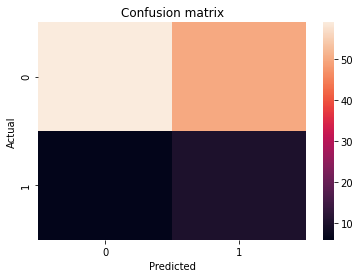

In [96]:
test_acc2, test_loss2, report2, matrix2  = logesticRegressionModel.test()

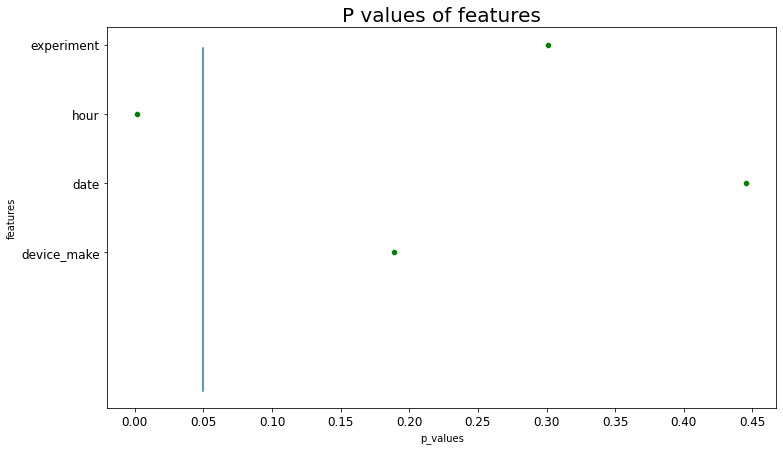

,features,p_values
0,experiment,0.301213
1,hour,0.001876
2,date,0.445320
3,device_make,0.189161


In [97]:

p_values_df = logesticRegressionModel.get_p_values()
logesticRegressionModel.plot_pvalues(p_values_df)
p_values_df


The P-value for experiment is 0.3. It is not that much significant, since our significance level is 0.05. Hour is the most important predictor for the Logestic Regression Model with p value 0.001, it is then follwed by device_make then experiment. The least predictor for the Logestic Regression Model is date